In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
import optuna 
from optuna import Trial 
import lightgbm as lgb 
from sklearn.metrics import log_loss,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
#from imblearn.under_sampling import ClusterCentroids,TomekLinks,RandomUnderSampler
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

import xgboost as xgb
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV


sns.set()

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

In [77]:
train = pd.read_csv(r'C:\Users\Deepesh\Desktop\ML_notebooks\jan-hackathon\train_BRCpofr.csv')#test_koRSKBP

In [78]:
test = pd.read_csv(r'C:\Users\Deepesh\Desktop\ML_notebooks\jan-hackathon\test_koRSKBP.csv')

In [79]:
train.describe()

,id,marital_status,vintage,claim_amount,cltv
count,89392.00,89392.00,89392.00,89392.00,89392.00
mean,44696.50,0.58,4.60,4351.50,97952.83
std,25805.39,0.49,2.29,3262.36,90613.81
min,1.00,0.00,0.00,0.00,24828.00
25%,22348.75,0.00,3.00,2406.00,52836.00
50%,44696.50,1.00,5.00,4089.00,66396.00
75%,67044.25,1.00,6.00,6094.00,103440.00
max,89392.00,1.00,8.00,31894.00,724068.00


In [80]:
train.columns

Index(['id', 'gender', 'area', 'qualification', 'income', 'marital_status',
       'vintage', 'claim_amount', 'num_policies', 'policy', 'type_of_policy',
       'cltv'],
      dtype='object')

In [81]:
train['gender'] = train['gender'].map({'Male':1,'Female':0})
train['income'] = train['income'].map({'<=2L':0,'2L-5L':1,'5L-10L':2,'More than 10L':3})
train['num_policies'] = train['num_policies'].map({'1':0,'More than 1':1})
train['policy'] = train['policy'].map({'A':0,'B':1,'C':2})
train['type_of_policy'] = train['type_of_policy'].map({'Platinum':2,'Silver':0,'Gold':1})
train['area'] = train['area'].map({'Urban':1,'Rural':0})
train['qualification'] = train['qualification'].map({'High School':0,'Bachelor':1,'Others':2})

In [82]:
test['gender'] = test['gender'].map({'Male':1,'Female':0})
test['income'] = test['income'].map({'<=2L':0,'2L-5L':1,'5L-10L':2,'More than 10L':3})
test['num_policies'] = test['num_policies'].map({'1':0,'More than 1':1})
test['policy'] = test['policy'].map({'A':0,'B':1,'C':2})
test['type_of_policy'] = test['type_of_policy'].map({'Platinum':2,'Silver':0,'Gold':1})
test['area'] = test['area'].map({'Urban':1,'Rural':0})
test['qualification'] = test['qualification'].map({'High School':0,'Bachelor':1,'Others':2})

<AxesSubplot:>

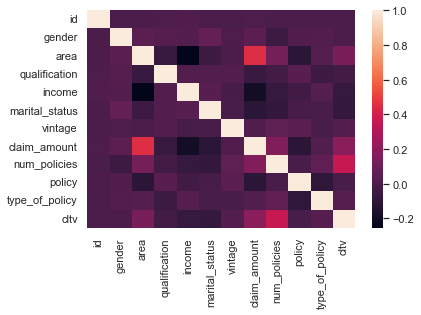

In [100]:
sns.heatmap(train.corr(),annot=False)

In [83]:
train.columns

Index(['id', 'gender', 'area', 'qualification', 'income', 'marital_status',
       'vintage', 'claim_amount', 'num_policies', 'policy', 'type_of_policy',
       'cltv'],
      dtype='object')

In [184]:
# original feature set don't touch
features = [
    'gender',
 'area',
 'qualification',
 'income',
 'marital_status',
 'vintage',
 'claim_amount',
 'num_policies',
 'policy',
 'type_of_policy']


In [185]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train['cltv'], test_size=0.2, random_state=42)

## Feature Selection Code (not worked)

In [186]:
# %time

#from mlxtend.feature_selection import SequentialFeatureSelector
#from sklearn.linear_model import LinearRegression
# # Assume that X_train, X_test, y_train, y_test are the train and test data and labels

# def objective(trial):
#     # Define the parameter domain
#     params = {
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 200),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#     }

#     # Create a LightGBM regressor
#     regressor = lgb.LGBMRegressor(**params)

#     # Fit the regressor on the training data
#     regressor.fit(X_train, y_train)

#     # Make predictions on the test data
#     y_pred = regressor.predict(X_test)

#     # Calculate the R-squared score
#     r2 = r2_score(y_test, y_pred)

#     return 1 - r2  # Optuna minimizes the objective, so we need to negate R-squared.


# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print("Best parameters: ", study.best_params)
# print("Best R-squared score: ", 1 - study.best_value)

# # Use the best parameters to make predictions on the test data
# regressor = lgb.LGBMRegressor(**study.best_params)
# regressor.fit(X_train, y_train)
# y_pred = regressor.predict(X_test)

# # Calculate R-squared score on the test data
# r2_test = r2_score(y_test, y_pred)
# print("R-squared score on test data: ", r2_test)


In [187]:
## will use this list set in .fit 

feat = [
 'gender',
 'area',
 'qualification',
 'income',
 'marital_status',
 'vintage',
 'claim_amount',
 'num_policies',
 'policy',
 'type_of_policy']


## Feature Selection

In [188]:


# # Assume that X_train and y_train are the training data and labels, respectively

# # Initialize the feature selector
# selector = SequentialFeatureSelector(m1, 
#                                      k_features=8,  # number of features to select
#                                      forward=True,  # use forward selection
#                                      scoring='r2',  # use R-squared score as the evaluation metric
#                                      cv=5,n_jobs=-1)  # use 5-fold cross-validation

# # Perform feature selection
# #selector.fit(X_train, y_train)
# selector.fit(X_train, y_train)#, iterations=tqdm(range(1, X_train.shape[1]+1)))

# # Get the selected features
# selected_features = list(selector.k_feature_idx_)

# # Get the new data with only the selected features
# new_feature_list = list(X_train.iloc[:, selected_features].columns)


In [189]:
params ={'learning_rate': 0.04028787950144536, 
         'num_leaves': 7, 
         'bagging_freq': 15,
         'min_child_samples': 550}

In [190]:
m1 =lgb.LGBMRegressor(random_state=46,min_child_samples = 550,num_leaves=7,learning_rate= 0.08028787950144536,n_estimators= 80)
#m1 =lgb.LGBMRegressor(**params,random_state=46,objective ='regression')

In [191]:
#m1 = xgb.XGBRegressor(n_estimators=500,max_depth=3,n_jobs=-1,max_leaves=7,)

In [192]:
m1.fit(X_train[feat],y_train)

LGBMRegressor(learning_rate=0.08028787950144536, min_child_samples=550,
              n_estimators=80, num_leaves=7, random_state=46)

In [193]:
y_pred =m1.predict(X_test[feat])

In [194]:
r2_score(y_test,y_pred)

0.16053773794900583

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

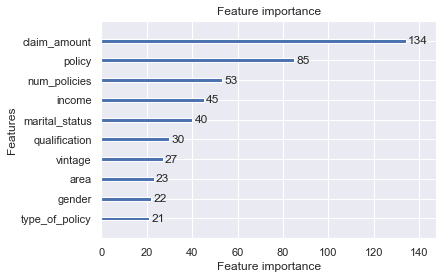

In [195]:
lgb.plot_importance(m1, max_num_features=20)

In [76]:
#temp_score= set()

In [73]:
try :
    score=r2_score(y_test,y_pred)
    temp_score.add(score)
except:
    print("Score are same")
    
score    

0.3279286612061212

In [49]:
temp_score

{0.3279286612061212}

## Stack boosting code (jassi)

In [200]:
cat_cols = ['gender',
 'area',
 'qualification',
 'income',
 'marital_status',
 'vintage',
  'policy','type_of_policy']

In [196]:
from sklearn.model_selection import KFold
import pandas as pd
from typing import Union

class SplitModelObjectHolder():
    def __init__(self):
        self.models = []

    def add_model(self, model):
        self.models.append(model)

    def predict(self, dataframe):
        result = 0
        for model in self.models:
            result +=  model.predict(dataframe) 
        return result/len(self.models)


class SplitObject:
    """ _summary_

    _extended_summary_
    """
    def __init__(self, n_splits: int = 4, random_state: int = 0):
        """_summary_

        Parameters
        ----------
        n_splits : int, optional
            _description_, by default 3
        random_state : int, optional
            _description_, by default 0
        """
        self.n_splits = n_splits
        self.random_state = random_state

    def fit(self, x_train: pd.DataFrame,
            y: pd.Series,
            feature_list: list = None,
            stratify_on : Union[str, pd.Series] = None,
            model_list: list = None,
            model_instance=None,
           cat_cols=None):
        """_summary_

        Parameters
        ----------
        model_list : list
            _description_
        """
        # The idea is of a single automl object, so we will have to figure out
        # when it is a classification (stratified) and when it is not
        # Also why not stratify in regression using bins???
        
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        features = x_train.colunms if feature_list is None else feature_list
        x_train["oof_predictions"] = 0
        self.model_holder = SplitModelObjectHolder()
        #print(self.model_holder.models)
        stratify_on_column =  y if stratify_on is None else x_train[stratify_on]


        for fold, (train_idx, valid_idx) in enumerate(skf.split(x_train, stratify_on_column)):
            valid_x = x_train.loc[valid_idx, features]
            valid_y = y.loc[valid_idx]

            train_x = x_train.loc[train_idx, features]
            train_y = y.loc[train_idx]

            # 2. need to have the individual models in each split saved
            #model = model_instance  # need to figure out
            model_instance = CatBoostRegressor(iterations=2000,od_type = "Iter",od_wait = 500)

            model_instance.fit(train_x, 
                               train_y,cat_features =cat_cols, 
                               eval_set=[(valid_x, valid_y)],
                               verbose=500)

            #oof_preds = np.exp( model_instance.predict(valid_x) )
            #print(self.model_holder.models, model_instance)

            self.model_holder.add_model(model_instance)  # posttible solution to 2. ?
            #print(self.model_holder.models)

            x_train.loc[valid_idx, "oof_predictions"] = self.model_holder.predict(valid_x)
            
        return x_train, self.model_holder


In [197]:
first = SplitObject(random_state=27031997)

In [201]:
# m1 = lgb.LGBMRegressor(random_state=46,min_child_samples = 550,num_leaves=7,learning_rate= 0.08028787950144536,n_estimators= 80)
# m1 is my tunned model
x_train, model_holder = first.fit(train,
                                  train['cltv'],
                                 features,
                                 model_instance = m1,
                                  cat_cols=cat_cols)

Learning rate set to 0.064566
0:	learn: 89312.4027774	test: 90986.1979057	best: 90986.1979057 (0)	total: 68.1ms	remaining: 2m 16s
500:	learn: 81891.1046690	test: 84400.6881613	best: 84347.7997264 (227)	total: 24.1s	remaining: 1m 12s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 84347.79973
bestIteration = 227

Shrink model to first 228 iterations.
Learning rate set to 0.064566
0:	learn: 89703.4035970	test: 89834.0436256	best: 89834.0436256 (0)	total: 71.3ms	remaining: 2m 22s
500:	learn: 82373.9981934	test: 83106.5179977	best: 83087.6197675 (336)	total: 24s	remaining: 1m 11s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 83087.61977
bestIteration = 336

Shrink model to first 337 iterations.
Learning rate set to 0.064566
0:	learn: 89666.6341880	test: 89924.2361966	best: 89924.2361966 (0)	total: 83ms	remaining: 2m 45s
500:	learn: 82320.2925769	test: 83289.5713765	best: 83263.4459465 (189)	total: 25.9s	remaining: 1m 17s
Stopped by overfitting detect

In [202]:
first.model_holder.models

In [203]:
r2_score(x_train['cltv'],x_train['oof_predictions'])

0.16247664021863673

In [204]:
second = SplitObject(random_state=27061997)

x_train, model_holder = second.fit(train,
                                  train['cltv'],
                                     features,
                                     model_instance = m1,
                                      cat_cols=cat_cols)
second.model_holder.models

Learning rate set to 0.064566
0:	learn: 89919.7424567	test: 89170.3085260	best: 89170.3085260 (0)	total: 66.9ms	remaining: 2m 13s
500:	learn: 82543.8138099	test: 82511.6463582	best: 82503.2046418 (369)	total: 27s	remaining: 1m 20s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 82503.20464
bestIteration = 369

Shrink model to first 370 iterations.
Learning rate set to 0.064566
0:	learn: 89415.2786993	test: 90696.0404594	best: 90696.0404594 (0)	total: 73.2ms	remaining: 2m 26s
500:	learn: 82032.9088667	test: 83790.4657741	best: 83773.3386250 (369)	total: 29.7s	remaining: 1m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 83773.33862
bestIteration = 369

Shrink model to first 370 iterations.
Learning rate set to 0.064566
0:	learn: 89732.4801378	test: 89717.3531815	best: 89717.3531815 (0)	total: 67.5ms	remaining: 2m 14s
500:	learn: 82282.9135321	test: 83146.0978298	best: 83134.4652262 (293)	total: 27.8s	remaining: 1m 23s
Stopped by overfitting dete

In [205]:
r2_score(x_train['cltv'],x_train['oof_predictions'])

0.1633147840226814

In [206]:
# test submission of jassi_code
test['cltv']=model_holder.predict(test[features])
test[['id','cltv']].to_csv('sub_score0.1633147840226814.csv',index=False)

In [51]:
# #from lazypredict.Supervised import LazyRegressor
# # import pandas as pd

# # lazy predictor


# from sklearn.utils import shuffle
# # Assume X_train and y_train are the training data and labels, respectively

# # Create a LazyPredictor object with a Random Forest model

# X, y = shuffle(train[features], train['cltv'], random_state=13)
# X = X.astype(np.float32)

# offset = int(X.shape[0] * 0.9)

# X_train, y_train = X[:offset], y[:offset]
# X_test, y_test = X[offset:], y[offset:]

# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# # Fit the model on the training data

# print(models)

In [52]:
# # Assume that X_train, X_test, y_train, y_test are the train and test data and labels

# # Define the parameter grid for grid search
# param_grid = {'max_depth': [3, 5, 7],
#               'learning_rate': [0.1, 0.01, 0.001],
#               'n_estimators': [100, 200, 300],
#               'subsample': [0.8, 1],
#               'colsample_bytree': [0.8, 1]
#              }

# # Create an XGBoost regressor
# regressor = xgb.XGBRegressor()

# # Perform grid search using recall as the scoring metric
# grid_search = RandomizedSearchCV(regressor, param_grid, cv=5, scoring='r2', n_jobs=-1,verbose=True)

# #grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='recall', n_jobs=-1)

# # # wrap the grid_search.fit() method with tqdm
# # with tqdm(total=len(param_grid)) as pbar:
# #     grid_search.fit(X_train, y_train, callback=lambda *x: pbar.update())

# grid_search.fit(X_train, y_train)

# # Print the best parameters and recall score
# print("Best parameters: ", grid_search.best_params_)
# print("Best r2 score: ", grid_search.best_score_)

# # Use the best parameters to make predictions on the test data
# regressor = xgb.XGBRegressor(**grid_search.best_params_)
# regressor.fit(X_train, y_train)
# y_pred = regressor.predict(X_test)

# # Calculate recall on the test data
# recall_test = r2_score(y_test, y_pred)
# print("r2_score on test data: ", recall_test)


# To save the test file

In [54]:
m1.fit(train[features], train['cltv'])
test['cltv'] =m1.predict(test[features])
test[['id','cltv']].to_csv('sub_score0.1633147840226814.csv',index=False)

In [210]:
from sklearn.manifold import TSNE
import pandas as pd

# Assume X is the data with shape (n_samples, n_features)
X = train[feat]

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=5, learning_rate=20)
X_tsne = tsne.fit_transform(X)

# X_tsne will have shape (n_samples, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [111]:
def r2_metric(y_true, y_pred):
    SS_res =  keras.backend.sum(keras.backend.square(y_true - y_pred)) 
    SS_tot = keras.backend.sum(keras.backend.square(y_true - keras.backend.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + keras.backend.epsilon()) )

In [131]:


# Assume that X_train and y_train are the training data and labels, respectively

# Define the model architecture
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))

# Compile the model
#model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_metric])


# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=128)


Epoch 1/200
559/559 [==============================] - 1s 938us/step - loss: 10785110016.0000 - r2_metric: -0.3270
Epoch 2/200
559/559 [==============================] - 1s 901us/step - loss: 9131646976.0000 - r2_metric: -0.1243
Epoch 3/200
559/559 [==============================] - 0s 842us/step - loss: 8860181504.0000 - r2_metric: -0.0881
Epoch 4/200
559/559 [==============================] - 0s 844us/step - loss: 8756101120.0000 - r2_metric: -0.0747
Epoch 5/200
559/559 [==============================] - 0s 853us/step - loss: 8586178048.0000 - r2_metric: -0.0547
Epoch 6/200
559/559 [==============================] - 1s 901us/step - loss: 8364395008.0000 - r2_metric: -0.0262
Epoch 7/200
559/559 [==============================] - 1s 1ms/step - loss: 8132291072.0000 - r2_metric: 0.0060
Epoch 8/200
559/559 [==============================] - 0s 891us/step - loss: 7998857216.0000 - r2_metric: 0.0177
Epoch 9/200
559/559 [==============================] - 0s 848us/step - loss: 7922621440.000

559/559 [==============================] - 1s 996us/step - loss: 7090644992.0000 - r2_metric: 0.1345
Epoch 73/200
559/559 [==============================] - 1s 933us/step - loss: 7075986944.0000 - r2_metric: 0.1365
Epoch 74/200
559/559 [==============================] - 1s 920us/step - loss: 7127996928.0000 - r2_metric: 0.1274
Epoch 75/200
559/559 [==============================] - 1s 992us/step - loss: 7100423680.0000 - r2_metric: 0.1330
Epoch 76/200
559/559 [==============================] - 1s 902us/step - loss: 7081728512.0000 - r2_metric: 0.1365
Epoch 77/200
559/559 [==============================] - 0s 852us/step - loss: 7068885504.0000 - r2_metric: 0.1364
Epoch 78/200
559/559 [==============================] - 0s 834us/step - loss: 7081987584.0000 - r2_metric: 0.1348
Epoch 79/200
559/559 [==============================] - 0s 834us/step - loss: 7096436224.0000 - r2_metric: 0.1320
Epoch 80/200
559/559 [==============================] - 0s 830us/step - loss: 7062040576.0000 - r2_me

559/559 [==============================] - 0s 858us/step - loss: 7051845632.0000 - r2_metric: 0.1402
Epoch 144/200
559/559 [==============================] - 0s 840us/step - loss: 7074196992.0000 - r2_metric: 0.1369
Epoch 145/200
559/559 [==============================] - 0s 843us/step - loss: 7084746240.0000 - r2_metric: 0.1343
Epoch 146/200
559/559 [==============================] - 0s 841us/step - loss: 7053296640.0000 - r2_metric: 0.1383
Epoch 147/200
559/559 [==============================] - 0s 842us/step - loss: 7058368512.0000 - r2_metric: 0.1388
Epoch 148/200
559/559 [==============================] - 0s 832us/step - loss: 7069576704.0000 - r2_metric: 0.1367
Epoch 149/200
559/559 [==============================] - 0s 840us/step - loss: 7073662464.0000 - r2_metric: 0.1360
Epoch 150/200
559/559 [==============================] - 0s 829us/step - loss: 7073477120.0000 - r2_metric: 0.1354
Epoch 151/200
559/559 [==============================] - 0s 855us/step - loss: 7041375744.0000

In [132]:
y_pred =model.predict(X_test)
r2_score(y_test,y_pred)

559/559 [==============================] - 0s 579us/step


0.15173534416082846

In [92]:
#temp_score= set()

In [95]:
try :
    score=r2_score(y_test,y_pred)
    temp_score.add(score)
except:
    print("Score are same")
    
score    

0.1600810586928051